In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import os
from matplotlib import pyplot as plot

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
dir_name = os.getcwd()

In [4]:
def get_norm_params_cifar10():
    dataset = torchvision.datasets.CIFAR10(
        root = dir_name,
        train = True,
        download = True
    ).data / 255
    dataset = dataset.reshape((-1, 3))
    mean = dataset.mean(axis=0)
    std = dataset.std(axis=0)
    return mean, std

In [5]:
mean, std = get_norm_params_cifar10()

print(f'mean = {mean}')
print(f'std = {std}')

Files already downloaded and verified
mean = [0.49139968 0.48215841 0.44653091]
std = [0.24703223 0.24348513 0.26158784]


In [6]:
def get_orig_img_hwc(img, mean, std):
    # img.shape is (3, 32, 32)
    mean_torch = torch.tensor(mean).reshape((3, 1, 1))
    std_torch = torch.tensor(std).reshape((3, 1, 1))
    img_converted = (img * std_torch + mean_torch) * 255
    return img_converted.to(torch.uint8).numpy().transpose(1, 2, 0)

In [7]:
def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        ax.imshow(get_orig_img_hwc(images[i][0], mean, std))

In [8]:
train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name,
    train = True,
    download = True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, std)
    ])
)

Files already downloaded and verified


In [9]:
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name,
    train = False,
    download = True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, std)
    ])
)

Files already downloaded and verified


Number of train samples: 50000
Shape of train tensor: (50000, 32, 32, 3)


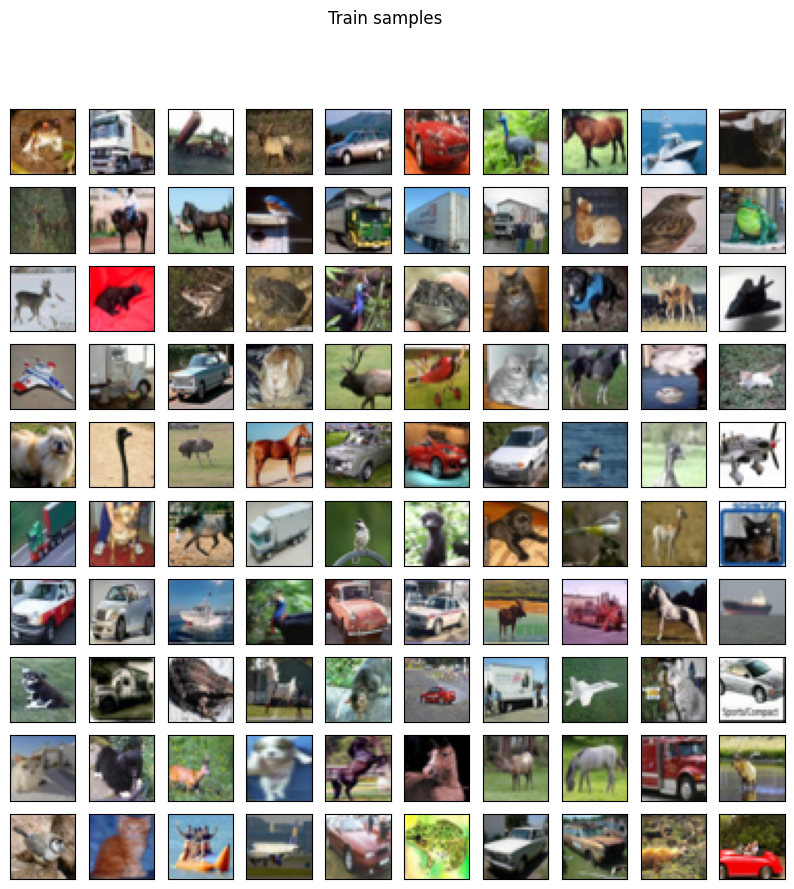

In [10]:
print('Number of train samples: {}'.format(len(train_dataset)))
print('Shape of train tensor: {}'.format(train_dataset.data.shape))
show_images(train_dataset, 'Train samples')

Number of test samples: 10000


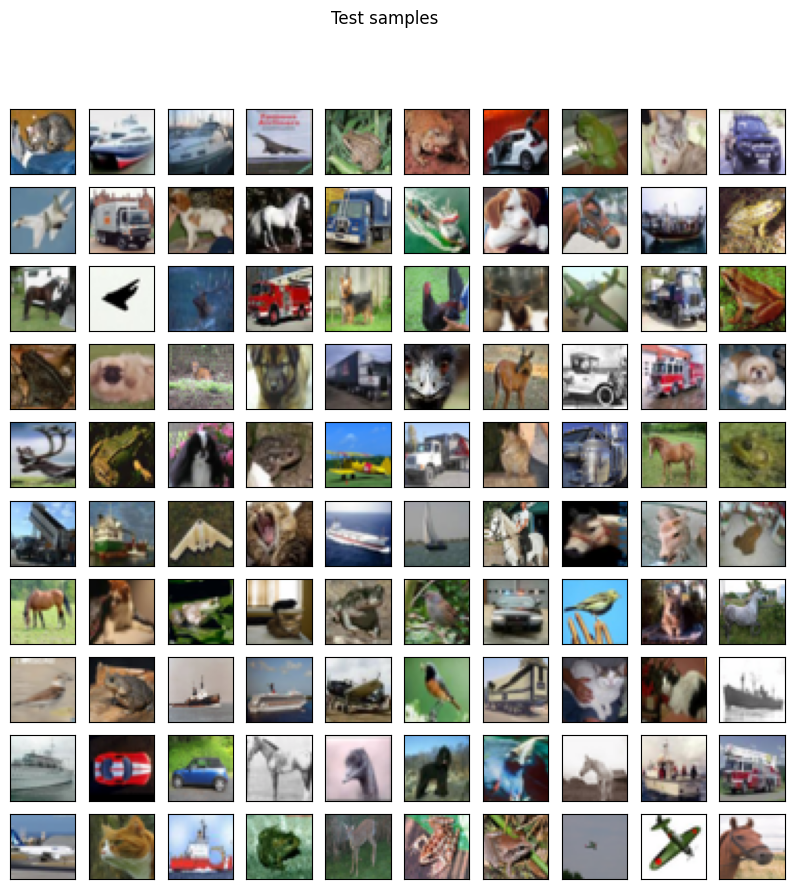

In [11]:
print('Number of test samples: {}'.format(len(test_dataset)))
show_images(test_dataset, 'Test samples')

In [12]:
batch_size = 50

In [13]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True
)

In [14]:
test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [16]:
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

In [17]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size = 3),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 3)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size = 3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 3, stride = 2)
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU()
        )

        self.fc = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, 100),
            torch.nn.ReLU()
        )

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(100, num_classes)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc2(out)
        return out

cnn_model = CNN().to(device)

from torchsummary import summary
summary(cnn_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
       BatchNorm2d-2           [-1, 64, 30, 30]             128
              ReLU-3           [-1, 64, 30, 30]               0
         MaxPool2d-4           [-1, 64, 10, 10]               0
            Conv2d-5            [-1, 128, 8, 8]          73,856
       BatchNorm2d-6            [-1, 128, 8, 8]             256
              ReLU-7            [-1, 128, 8, 8]               0
         MaxPool2d-8            [-1, 128, 3, 3]               0
            Conv2d-9            [-1, 256, 1, 1]         295,168
      BatchNorm2d-10            [-1, 256, 1, 1]             512
             ReLU-11            [-1, 256, 1, 1]               0
          Dropout-12                  [-1, 256]               0
           Linear-13                  [-1, 100]          25,700
             ReLU-14                  [

In [18]:
import time

t_total = 0
learning_rate = 0.01
num_epochs = 20

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    t_start = time.time()

    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn_model(images)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    t_final = time.time()
    t_total += (t_final - t_start)

    print('Epoch[{}/{}]: accuracy = {}  exec_time = {}'.
          format(epoch + 1, num_epochs,
                 get_accuracy(train_data_loader, cnn_model),
                 t_final - t_start))

print(f'\tTotal time: {t_total}')

Epoch[1/20]: accuracy = 0.5839799642562866  exec_time = 18.330132246017456
Epoch[2/20]: accuracy = 0.6374599933624268  exec_time = 18.136335849761963
Epoch[3/20]: accuracy = 0.6692000031471252  exec_time = 18.31756854057312
Epoch[4/20]: accuracy = 0.6789399981498718  exec_time = 18.81100106239319
Epoch[5/20]: accuracy = 0.7003399729728699  exec_time = 19.33215880393982
Epoch[6/20]: accuracy = 0.6976000070571899  exec_time = 18.361225843429565
Epoch[7/20]: accuracy = 0.7117199897766113  exec_time = 17.71832013130188
Epoch[8/20]: accuracy = 0.7171199917793274  exec_time = 17.92061734199524
Epoch[9/20]: accuracy = 0.7213000059127808  exec_time = 18.556997537612915
Epoch[10/20]: accuracy = 0.7297999858856201  exec_time = 18.516658306121826
Epoch[11/20]: accuracy = 0.7203399538993835  exec_time = 19.29310631752014
Epoch[12/20]: accuracy = 0.7377199530601501  exec_time = 17.68602442741394
Epoch[13/20]: accuracy = 0.7482799887657166  exec_time = 18.05461573600769
Epoch[14/20]: accuracy = 0.74

In [19]:
print('Test accuracy: {}'.format(get_accuracy(test_data_loader, cnn_model)))

Test accuracy: 0.7114999890327454


In [20]:
class ResNetLike(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetLike, self).__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size = 3),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 3)
        )

        self.res_block_1 = torch.nn.Sequential(
            torch.nn.Sequential(
                torch.nn.Conv2d(64, 64, kernel_size = 1),
                torch.nn.BatchNorm2d(64),
                torch.nn.ReLU()
            ),
            torch.nn.Sequential(
                torch.nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
                torch.nn.BatchNorm2d(64),
                torch.nn.ReLU()
            ),
            torch.nn.Sequential(
                torch.nn.Conv2d(64, 128, kernel_size = 1),
                torch.nn.BatchNorm2d(128),
                torch.nn.ReLU()
            )
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size = 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU()
        )

        self.res_block_2 = torch.nn.Sequential(
            torch.nn.Sequential(
                torch.nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
                torch.nn.BatchNorm2d(128),
                torch.nn.ReLU()
            ),
            torch.nn.Sequential(
                torch.nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
                torch.nn.BatchNorm2d(128),
                torch.nn.ReLU()
            )
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2)
        )

        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, kernel_size=3),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2)
        )

        self.fc = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU()
        )

        self.fc1 = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, 100),
            torch.nn.ReLU()
        )

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(100, num_classes)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.res_block_1(out) + self.conv2(out)
        out = self.res_block_2(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

resnet_model = ResNetLike().to(device)
summary(resnet_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
       BatchNorm2d-2           [-1, 64, 30, 30]             128
              ReLU-3           [-1, 64, 30, 30]               0
         MaxPool2d-4           [-1, 64, 10, 10]               0
            Conv2d-5           [-1, 64, 10, 10]           4,160
       BatchNorm2d-6           [-1, 64, 10, 10]             128
              ReLU-7           [-1, 64, 10, 10]               0
            Conv2d-8           [-1, 64, 10, 10]          36,928
       BatchNorm2d-9           [-1, 64, 10, 10]             128
             ReLU-10           [-1, 64, 10, 10]               0
           Conv2d-11          [-1, 128, 10, 10]           8,320
      BatchNorm2d-12          [-1, 128, 10, 10]             256
             ReLU-13          [-1, 128, 10, 10]               0
           Conv2d-14          [-1, 128,

In [21]:
t_total = 0
learning_rate = 0.01
num_epochs = 20

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet_model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    t_start = time.time()

    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet_model(images)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    t_final = time.time()
    t_total += (t_final - t_start)

    print('Epoch[{}/{}]: accuracy = {}  exec_time = {}'.
          format(epoch + 1, num_epochs,
                 get_accuracy(train_data_loader, resnet_model),
                 t_final - t_start))

print(f'\tTotal time: {t_total}')

Epoch[1/20]: accuracy = 0.4607999920845032  exec_time = 21.246692895889282
Epoch[2/20]: accuracy = 0.5572199821472168  exec_time = 21.516122817993164
Epoch[3/20]: accuracy = 0.6054399609565735  exec_time = 27.41421365737915
Epoch[4/20]: accuracy = 0.6507399678230286  exec_time = 21.312061071395874
Epoch[5/20]: accuracy = 0.6794799566268921  exec_time = 22.695743322372437
Epoch[6/20]: accuracy = 0.6990399956703186  exec_time = 22.165097951889038
Epoch[7/20]: accuracy = 0.7111799716949463  exec_time = 21.344305276870728
Epoch[8/20]: accuracy = 0.7159199714660645  exec_time = 21.8202064037323
Epoch[9/20]: accuracy = 0.7437799572944641  exec_time = 21.954416751861572
Epoch[10/20]: accuracy = 0.754539966583252  exec_time = 21.850624084472656
Epoch[11/20]: accuracy = 0.766979992389679  exec_time = 21.571714162826538
Epoch[12/20]: accuracy = 0.7711600065231323  exec_time = 21.340728282928467
Epoch[13/20]: accuracy = 0.7762199640274048  exec_time = 22.740222215652466
Epoch[14/20]: accuracy = 0

In [22]:
print('Test accuracy: {}'.format(get_accuracy(test_data_loader, resnet_model)))

Test accuracy: 0.7524999976158142
